In [1]:
import pandas as pd
from scipy.special import binom
from tqdm import tqdm
from itertools import combinations
from pathlib import Path
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


def rec_dd():
    return defaultdict(rec_dd)


In [2]:
benchmark_path = Path(
    "/home/gabrielathenes/Documents/study/HILARy/data_with_scripts/benchmark_on_partis_dataset"
)
hilary_full = "hilary-full-1-2-0"
hilary_cdr3 = "hilary-cdr3-1-2-0"


In [3]:
def pairwise_evaluation(df, partition, ground_truth="simulations"):
    TP = 0
    P = binom(df.groupby([ground_truth]).size(), 2).sum()
    TP_FP = binom(df.groupby([partition]).size(), 2).sum()
    for _, family in tqdm(df.groupby([ground_truth]), disable=True):
        for r1, r2 in combinations(family[partition], 2):
            if r1 == r2:
                TP += 1
    if TP_FP == 0:
        return 0.0, 1.0
    elif P == 0:
        return None, None
    return (
        TP / P,
        TP / TP_FP,
    )  # sensitivity, precision

def entropy(dfGrouped):
    fs = dfGrouped.size()
    fs = fs / sum(fs)
    return sum(fs * np.log2(fs))


def variation_of_info(df, result):
    VI = (
        entropy(df.groupby(["simulations"]))
        + entropy(df.groupby([result]))
        - 2 * entropy(df.groupby([result, "simulations"]))
    )
    return VI


In [4]:
metric_dict=rec_dd()
for seed in [0, 1, 2]:
    prec_list=[]
    sens_list=[]
    var_list=[]
    for freq in ["0.01","0.05","0.10","0.20","0.30"]:
        dataframe=pd.DataFrame()
        for model in ["simulations","partis","scoper",hilary_full,hilary_cdr3,"alignment_free"]:
            if model.startswith("alignment"):
                df = pd.read_csv(
                    [
                        each
                        for each in (
                            benchmark_path
                            / Path(
                                f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/"
                            )
                        ).glob(f"*igh.tsv")
                    ][0],
                    sep=",",
                    index_col="sequence_id",
                )
            else :
                df = pd.read_csv(
                    [
                        each
                        for each in (benchmark_path
                        / Path(
                            f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/"
                        )).glob(f"*igh.tsv")
                    ][0],
                    sep="\t",
                    index_col="sequence_id",
                )
            if model.startswith("hilary-full"):
                dataframe[model]=df["family"]
                dataframe["cdr3_length"] = df["cdr3_length"]

            if model.startswith("hilary-cdr3"):
                dataframe[model]=df["cdr3_based_family"]
            elif model.startswith("alignment"):
                dataframe[model] = df["CLONE"]
            else :
                dataframe[model]=df["clone_id"]

            sensitivity,precision=pairwise_evaluation(dataframe,model)
            varinfo = variation_of_info(dataframe,model)
            metric_dict[model]["precision"][freq][seed]=precision
            metric_dict[model]["sensitivity"][freq][seed]=sensitivity
            metric_dict[model]["variation_of_info"][freq][seed]=varinfo


/tmp/ipykernel_2755194/2878224270.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_2755194/2878224270.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_2755194/2878224270.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_2755194/2878224270.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_2755194/2878224270.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_2755194/2878224270.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df =

precision
sensitivity
variation_of_info
precision
sensitivity
variation_of_info
HILARy-full
precision
sensitivity
variation_of_info
precision
sensitivity
variation_of_info
precision
sensitivity
variation_of_info


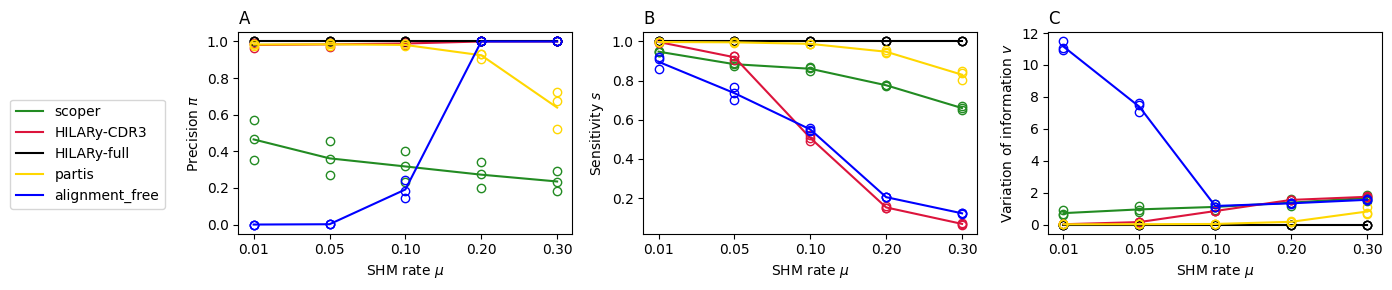

In [9]:
ls = [0.01,0.05,0.10,0.20,0.30]
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(131)
ax1.set_ylabel(r"Precision $\pi$")
ax1.set_xlabel(r"SHM rate $\mu$")
ax2 = fig.add_subplot(132)
ax2.set_ylabel("Sensitivity $s$")
ax2.set_xlabel(r"SHM rate $\mu$")
ax3 = fig.add_subplot(133)
ax3.set_ylabel(r"Variation of information $v$")
ax3.set_xlabel(r"SHM rate $\mu$")

colors={"scoper":"forestgreen",hilary_cdr3:"crimson",hilary_full:"k","partis":"gold","alignment_free":"blue"}
axes=[ax1,ax2,ax3]

for model in colors:
    if model == hilary_full:
        label = "HILARy-full"
        print(label)
    elif model == hilary_cdr3:
        label = "HILARy-CDR3"
    else :
        label=model
    for i,metric in enumerate(metric_dict[model]):
        print(metric)
        for freq in metric_dict[model][metric]:
            y=list(metric_dict[model][metric][freq].values())
            x=[freq]*len(y)
            axes[i].plot(
                x, y, "o", fillstyle="none", color=colors[model],
            )
        lengths=[]
        averages=[]
        for freq in metric_dict[model][metric]:
            lengths.append(freq)
            averages.append(np.mean(list(metric_dict[model][metric][freq].values())))
        axes[i].plot(
            lengths,
            averages,
            color=colors[model],
            label=label,
        )
        axes[i].set_title(["A","B","C"][i],loc="left")

ax1.legend(bbox_to_anchor=(-2.5, -0.1, 2.3, 0.8))

plt.tight_layout()
plt.savefig(
    "/home/gabrielathenes/Dropbox/Natanael_lineages_inference/revisions_2024_01_26/figures/figureSI_PARTIS_shm.png",
)
plt.show()
